In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir('gdrive/My Drive/Super_resolution/brainSR')

In [ ]:
import os
from data.image_list import create_image_list
from data.dataset import create_dataset
from data.data_loader import create_dataloader
import torch
import time
import random
from collections import OrderedDict
import math
from math import log10
from utils import util, convert, metric

In [ ]:
opt = {
    "name": "espcn_x4",
    "model": "espcn",
    "gpu_ids": [0],
    "upscale_factor":4,
    "device": "cuda",

    "datasets":
        {
            "path":
                {
                "root": "data/BrainTumour",
                "folders": ["imagesTr", "imagesTs"]
                },
            "train":
                {
                "phase": "train",
                "batch_size": 64,
                "use_shuffle": True,
                "upscale_factor": 4,
                "scale": True,
                # "transform_H": {},
                "no_of_images": 725,
                "n_workers": 1
                },
            "valid":
                {
                "phase": "valid",
                "no_of_images": 20,
                "scale": True,
                "depth_padding": 1,
                "upscale_factor": 4                
                # "transform_H": {}
                }
    },

    
  "path": 
    {
        "root": ""
    },

  "network":
    {
        "norm_type": "batch",
#         "ngf": 64,
#         "ngb": 16,
#         "input_ngc": 1,
#         "output_ngc": 1
    },

  "train" : 
    {
        "manual_seed": 777,
        "niter": 20,
        "val_freq": 5,
        "lr": 1e-4,
        "criterion": "mse"
    },


    "logger": 
    {
        "print_freq": 100,
        "save_checkpoint_freq": 5
    }
}


In [ ]:
def parse(opt_path, is_train=True):
#     with open(opt_path, 'r') as f:
#         opt = json.load(f, object_pairs_hook=OrderedDict)
    opt['is_train'] = is_train

    for key, path in opt['path'].items():
        opt['path'][key] = os.path.expanduser(path)
    if is_train:
        experiments_root = os.path.join(opt['path']['root'], 'experiments', opt['name'])
        opt['path']['experiments_root'] = experiments_root
        opt['path']['options'] = experiments_root
        opt['path']['trained_models'] = os.path.join(experiments_root, 'trained_models')
        opt['path']['log'] = os.path.join(experiments_root, 'log')
    else:
        results_root = os.path.join(opt['path']['root'], 'results', opt['name'])
        opt['path']['results_root'] = results_root
        opt['path']['log'] = os.path.join(results_root, 'log')
        opt['path']['test_images'] = os.path.join(results_root, 'test_images')

    return opt

opt = parse(opt)


In [ ]:
training_image_list = create_image_list(opt, train=True)
valid_image_list = create_image_list(opt, valid=True)


0/725 images loaded
50/725 images loaded
100/725 images loaded
150/725 images loaded
200/725 images loaded
250/725 images loaded
300/725 images loaded
350/725 images loaded
400/725 images loaded
450/725 images loaded
500/725 images loaded
550/725 images loaded
600/725 images loaded
650/725 images loaded
700/725 images loaded
0/20 images loaded


In [ ]:
training_set = create_dataset(opt["datasets"]["train"], training_image_list)
valid_set = create_dataset(opt["datasets"]["valid"], valid_image_list)


In [ ]:
from models.models import create_model
model = create_model(opt)

Model [ESPCNModel] is created.


In [ ]:
from utils.logger import Logger
logger = Logger(opt)

In [ ]:
def validate(val_loader, val_size, depth, model, logger, epoch, current_step):
    print('Start validation phase ...')
    val_start_time = time.time()
    model.eval() # Change to eval mode. It is important for BN layers.

    val_results = OrderedDict()
    avg_psnr = 0.0 
    for val_data in val_loader:
        for slice_no in range(depth):
          val_data_slice = dict(H=val_data['H'][slice_no,:,:,:].unsqueeze(0),
                                L=val_data['L'][slice_no,:,:,:].unsqueeze(0))
          model.feed_data(val_data_slice)

          visuals = model.get_current_visuals()
          
          sr_img = visuals['super-resolution'] # uint8
          gt_img = visuals['ground-truth'] # uint8

          mse = model.criterion(sr_img, gt_img).item()
          psnr = 10 * log10(1 / mse)
          avg_psnr += psnr
    avg_psnr = avg_psnr / val_size / depth
    val_results['psnr'] = avg_psnr

    val_duration = time.time() - val_start_time
    # Save to log
    logger.print_results(val_results, epoch, current_step, val_duration, 'val')
    model.train() # Change back to train mode.


In [49]:
a = valid_set[0]
L = a['L']
H = a['H']

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [50]:
a = dict(L=a['L'], H=a['H'])

In [68]:
a['H'].shape

torch.Size([64, 1, 240, 240])

In [69]:
a['L'].shape

torch.Size([64, 1, 60, 60])

In [70]:
model.feed_data(a)
model.optimize_parameters(5)
visuals = model.get_current_visuals()

RuntimeError: ignored

In [57]:
model.parameters()

<generator object Module.parameters at 0x7fcf98e4e620>

In [40]:
sr_img = visuals['super-resolution']
gt_img = visuals['ground-truth']

In [35]:
print(sr_img.shape, gt_img.shape)

torch.Size([1, 240, 240]) torch.Size([240, 240])


In [36]:
mse = model.criterion(sr_img[0], gt_img).item()
mse

0.011536364443600178

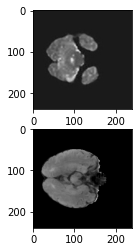

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].imshow(sr_img[0].detach().cpu().numpy(), cmap='gray')
axes[1].imshow(gt_img.detach().cpu().numpy(), cmap='gray')

In [34]:
10 * log10(1/mse)

19.37931032674537

In [ ]:
 # run this model
start_time = time.time()

val_size = len(valid_set)
depth = 624

for iteration in range(opt['train']['niter']+1):
    for i, train_data in enumerate(training_set):
        train_start_time = time.time()
        # training
        model.feed_data(train_data)
        model.optimize_parameters(i)
        train_duration = time.time() - train_start_time
        
        if i % opt['logger']['print_freq'] == 0:
            losses = model.get_current_losses()
            logger.print_results(losses, iteration, i, train_duration, 'loss')      
        

    if iteration != 0:
        # validation
        if iteration % opt['train']['val_freq'] == 0:
          validate(valid_set, val_size, depth, model, logger, iteration, i)

        # save
        if iteration % opt['logger']['save_checkpoint_freq'] == 0:
            print('Saving the model at the end of iteration %d' % (iteration))
            model.save(iteration)

    print('end of iteration ' + str(iteration))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(epoch:   0, iters:        0, time: 0.091) loss: 0.026517 
(epoch:   0, iters:      100, time: 0.087) loss: 0.001452 
(epoch:   0, iters:      200, time: 0.087) loss: 0.000996 
(epoch:   0, iters:      300, time: 0.086) loss: 0.001102 
(epoch:   0, iters:      400, time: 0.087) loss: 0.000883 
(epoch:   0, iters:      500, time: 0.087) loss: 0.000591 
(epoch:   0, iters:      600, time: 0.089) loss: 0.000764 
(epoch:   0, iters:      700, time: 0.086) loss: 0.000795 
end of iteration 0
(epoch:   1, iters:        0, time: 0.087) loss: 0.000495 
(epoch:   1, iters:      100, time: 0.086) loss: 0.000522 
(epoch:   1, iters:      200, time: 0.087) loss: 0.000440 
(epoch:   1, iters:      300, time: 0.086) loss: 0.000639 
(epoch:   1, iters:      400, time: 0.086) loss: 0.000703 
(epoch:   1, iters:      500, time: 0.087) loss: 0.000375 
(epoch:   1, iters:      600, time: 0.086) loss: 0.000581 
(epoch:   1, iters:      700, time: 0.087) loss: 0.000792 
end of iteration 1
(epoch:   2, iters

FileNotFoundError: ignored

In [18]:
torch.save(model, 'experiments/espcn_x4/5_ESPCN.pth')

In [16]:
1+1

2

In [59]:
a = training_set[0]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [61]:
a.keys()

dict_keys(['L', 'H'])

In [62]:
a['L'].shape

torch.Size([64, 1, 60, 60])

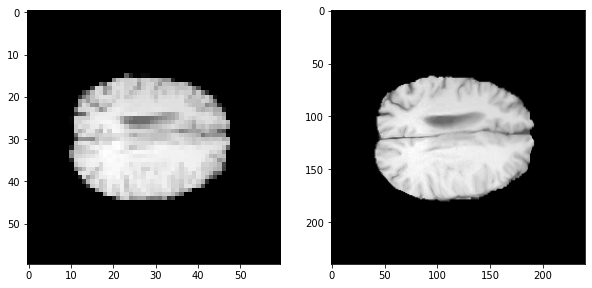

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].imshow(a['L'][30,0,:,:].detach().cpu().numpy(),cmap='gray')
axes[1].imshow(a['H'][30,0,:,:].detach().cpu().numpy(),cmap='gray')